In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
import math
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy import stats
from sklearn.metrics import mean_squared_error
from scipy import stats
from scipy.optimize import curve_fit


columns_to_read = ['CID', 'alcoholic', 'aldehydic', 'alliaceous', 'almond', 'amber', 'animal',
'anisic', 'apple', 'apricot', 'aromatic', 'balsamic', 'banana', 'beefy',
'bergamot', 'berry', 'bitter', 'black currant', 'brandy', 'burnt',
'buttery', 'cabbage', 'camphoreous', 'caramellic', 'cedar', 'celery',
'chamomile', 'cheesy', 'cherry', 'chocolate', 'cinnamon', 'citrus', 'clean',
'clove', 'cocoa', 'coconut', 'coffee', 'cognac', 'cooked', 'cooling',
'cortex', 'coumarinic', 'creamy', 'cucumber', 'dairy', 'dry', 'earthy',
'ethereal', 'fatty', 'fermented', 'fishy', 'floral', 'fresh', 'fruit skin',
'fruity', 'garlic', 'gassy', 'geranium', 'grape', 'grapefruit', 'grassy',
'green', 'hawthorn', 'hay', 'hazelnut', 'herbal', 'honey', 'hyacinth',
'jasmin', 'juicy', 'ketonic', 'lactonic', 'lavender', 'leafy', 'leathery',
'lemon', 'lily', 'malty', 'meaty', 'medicinal', 'melon', 'metallic',
'milky', 'mint', 'muguet', 'mushroom', 'musk', 'musty', 'natural', 'nutty',
'odorless', 'oily', 'onion', 'orange', 'orangeflower', 'orris', 'ozone',
'peach', 'pear', 'phenolic', 'pine', 'pineapple', 'plum', 'popcorn',
'potato', 'powdery', 'pungent', 'radish', 'raspberry', 'ripe', 'roasted',
'rose', 'rummy', 'sandalwood', 'savory', 'sharp', 'smoky', 'soapy',
'solvent', 'sour', 'spicy', 'strawberry', 'sulfurous', 'sweaty', 'sweet',
'tea', 'terpenic', 'tobacco', 'tomato', 'tropical', 'vanilla', 'vegetable',
'vetiver', 'violet', 'warm', 'waxy', 'weedy', 'winey', 'woody']

# Load the data
mixture_df = pd.read_csv('data/Mixure_Definitions_Training_set.csv')
training_data_df = pd.read_csv('data/TrainingData_mixturedist.csv')
MolecularProperty = pd.read_csv('data/openpom_ensemble_predictions_results.csv', usecols=columns_to_read)

# Standardize 'Dataset' names and ensure 'Mixture Label' and CIDs are numeric
mixture_df['Dataset'] = mixture_df['Dataset'].str.strip().str.lower()
training_data_df['Dataset'] = training_data_df['Dataset'].str.strip().str.lower()
mixture_df['Mixture Label'] = mixture_df['Mixture Label'].astype(int)
training_data_df['Mixture 1'] = training_data_df['Mixture 1'].astype(int)
training_data_df['Mixture 2'] = training_data_df['Mixture 2'].astype(int)
mixture_df_cids = mixture_df.filter(like='CID').apply(pd.to_numeric, errors='coerce')
MolecularProperty['CID'] = pd.to_numeric(MolecularProperty['CID'], errors='coerce')
mixture_df[mixture_df.filter(like='CID').columns] = mixture_df_cids


TASKS = columns_to_read[1:]  # All columns except 'CID'
MolecularProperty[TASKS] = MolecularProperty[TASKS].fillna(0)

# Initialize transformers
power_transformer = PowerTransformer()
quantile_transformer = QuantileTransformer(output_distribution='normal', n_quantiles=100)

# Apply QuantileTransformer
MolecularProperty_quantile = MolecularProperty.copy()
MolecularProperty_quantile[TASKS] = quantile_transformer.fit_transform(MolecularProperty[TASKS])


# Dictionary to store CID lists per mixture
mixtures_dict = {}
results = []

# Populate mixtures_dict with CIDs for each mixture, excluding identical mixtures
for index, row in training_data_df.iterrows():
    if row['Mixture 1'] != row['Mixture 2']:  # Exclude identical mixtures
        key = f"{row['Dataset']} Mixture {row['Mixture 1']} - Mixture {row['Mixture 2']}"
        mixture_1_df = mixture_df[(mixture_df['Dataset'] == row['Dataset']) & (mixture_df['Mixture Label'] == row['Mixture 1'])]
        mixture_2_df = mixture_df[(mixture_df['Dataset'] == row['Dataset']) & (mixture_df['Mixture Label'] == row['Mixture 2'])]

        cids_1 = mixture_1_df.filter(like='CID').values.flatten()
        cids_2 = mixture_2_df.filter(like='CID').values.flatten()
        # Convert lists to sets
        cids_1_set = set(cids_1)
        cids_2_set = set(cids_2)
        cids_1 = [int(cid) for cid in cids_1 if pd.notna(cid) and cid != 0] # and cid != cids_2]
        cids_2 = [int(cid) for cid in cids_2 if pd.notna(cid) and cid != 0] # and cid != cids_1]

        mixtures_dict[key] = (cids_1, cids_2)

def get_norm_mixture_quantile(cids_mixture):
    quantiles = MolecularProperty_quantile[MolecularProperty_quantile['CID'].isin(cids_mixture)]
    summed_quantiles = quantiles[TASKS].mean().values
    norm = np.linalg.norm(summed_quantiles)
    
    assert norm != 0
    
    return summed_quantiles / norm
        
# Calculate the summed values for each mixture and compute correlations, cosine similarity, and Euclidean distance
for key, (cids_mixture_1, cids_mixture_2) in mixtures_dict.items():
    assert len(cids_mixture_1) > 0 and len(cids_mixture_2) > 0

    summed_mixture_1_quantile = get_norm_mixture_quantile(cids_mixture_1)
    summed_mixture_2_quantile = get_norm_mixture_quantile(cids_mixture_2)

    # Check for NaNs after normalization
    if np.isnan(summed_mixture_1_quantile).any() or np.isnan(summed_mixture_2_quantile).any():
        print(f"NaNs after normalization for key {key}. Skipping.")
        continue

    # Proceed to compute the dot product and cosine similarity
    dot_product_quantile = np.dot(summed_mixture_1_quantile, summed_mixture_2_quantile)
    norm_quantile = np.linalg.norm(summed_mixture_1_quantile) * np.linalg.norm(summed_mixture_2_quantile)

    if norm_quantile != 0:
        cosine_of_angle = dot_product_quantile / norm_quantile
        clamped_cosine_of_angle = max(-1, min(1, cosine_of_angle))
        angle_quantile = math.acos(clamped_cosine_of_angle)
    else:
        angle_quantile = 0

    cosine_sim = cosine_similarity(
        summed_mixture_1_quantile.reshape(1, -1),
        summed_mixture_2_quantile.reshape(1, -1)
    )[0, 0]

    results.append({
        'Key': key,
        'Correlation_POM': 1 - np.corrcoef(summed_mixture_1_quantile, summed_mixture_2_quantile)[0, 1],
        'Cosine_Similarity_POM': 1 - cosine_sim,
        'Euclidean_Distance_POM': distance.euclidean(summed_mixture_1_quantile, summed_mixture_2_quantile),
        'Angle_POM': np.degrees(angle_quantile)
    })

result_df = pd.DataFrame(results)
# Function to extract numeric part safely
def extract_numeric(s):
    numbers = re.findall(r'\d+', s)
    if numbers:
        return int(numbers[0])  
    else:
        return None  

# Update result_df
result_df['Dataset'] = result_df['Key'].apply(lambda x: x.split(' Mixture ')[0].strip())
result_df['Mixture 1'] = result_df['Key'].apply(lambda x: extract_numeric(x.split(' Mixture ')[1].split(' - Mixture ')[0]))
result_df['Mixture 2'] = result_df['Key'].apply(lambda x: extract_numeric(x.split(' - Mixture ')[1]))

training_data_df = pd.merge(training_data_df, result_df[['Dataset', 'Mixture 1', 'Mixture 2','Correlation_POM','Cosine_Similarity_POM','Euclidean_Distance_POM','Angle_POM']], #,'DeltaSor']],
                            on=['Dataset', 'Mixture 1', 'Mixture 2'], how='left')
training_data_df = training_data_df.dropna()


# Convert results to DataFrame and print/save
result_df = pd.DataFrame(training_data_df)
print("Results:")
print(training_data_df.head())


Results:
   Dataset  Mixture 1  Mixture 2  Experimental Values  Correlation_POM  \
0  snitz 1          1          2             0.604167         0.415279   
1  snitz 1          1          3             0.651042         1.224227   
2  snitz 1          1          4             0.526042         0.891124   
3  snitz 1          1          5             0.505208         0.579633   
4  snitz 1          1          6             0.411458         0.705840   

   Cosine_Similarity_POM  Euclidean_Distance_POM   Angle_POM  
0               0.368819                0.858859   50.862724  
1               1.245150                1.578069  104.190711  
2               0.731895                1.209872   74.448453  
3               0.508588                1.008552   60.566587  
4               0.616917                1.110781   67.475245  


/var/folders/jv/6pqyzd1106l0jwdvbvjr5dn40000gn/T/ipykernel_62606/3788460506.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  regression_results = pd.concat([regression_results, pd.DataFrame({


Regression Results:
                 Variable  Pearson_Correlation      RMSE       p_value
0         Correlation_POM             0.545095  0.172453  4.922771e-62
1   Cosine_Similarity_POM             0.542684  0.172774  2.128649e-61
2  Euclidean_Distance_POM             0.583617  0.167033  6.188823e-73
3               Angle_POM             0.567717  0.169336  2.920178e-68

Predicted Experimental Values for 'Random', 'Angle', and 'Manual':

Pearson Correlation (Averaged Predictions vs Experimental Values): 0.41
RMSE (Averaged Predictions vs Experimental Values): 0.14
p-value (Averaged Predictions vs Experimental Values): 4.553e-03

Averaged predictions with standard deviation saved to 'Excluded_Datasets_Averaged_Predictions.csv'.


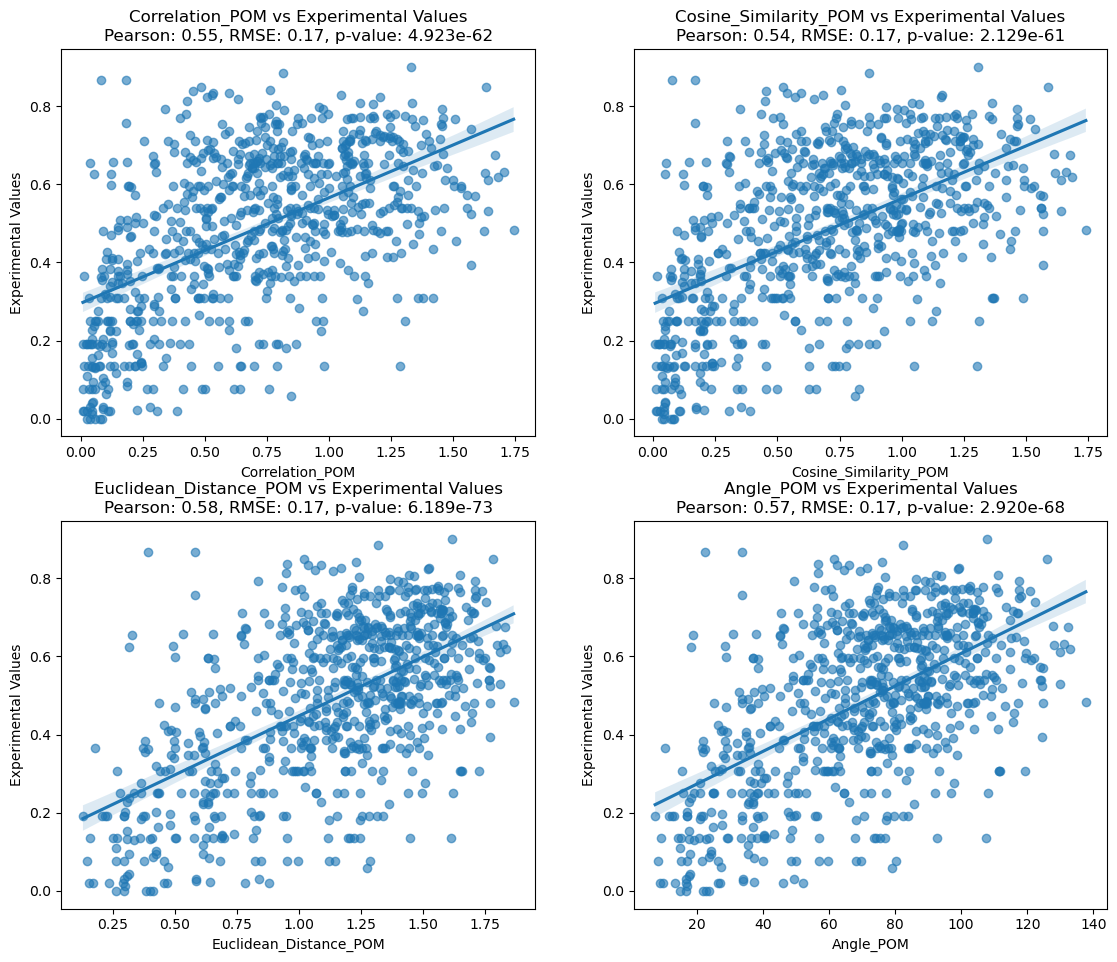

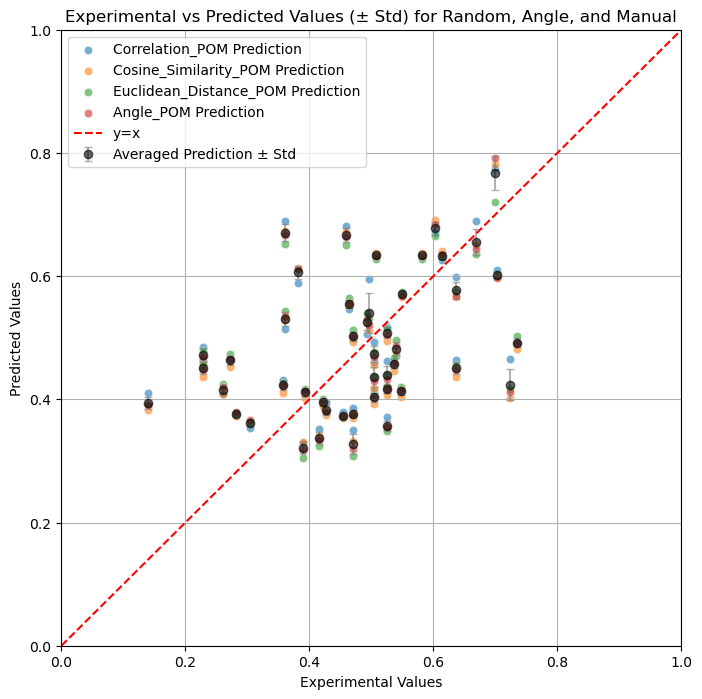

In [2]:
# Define the columns for regression
variables = [
    'Correlation_POM', 'Cosine_Similarity_POM',
     'Euclidean_Distance_POM', 'Angle_POM'
 ]

# Prepare the training data excluding 'Random', 'Angle', and 'Manual'
datasets_to_exclude = ['random', 'angle', 'manual']
training_data_excl_datasets = training_data_df[~training_data_df['Dataset'].isin(datasets_to_exclude)]

# Prepare a DataFrame to store results
regression_results = pd.DataFrame(columns=['Variable', 'Pearson_Correlation', 'RMSE', 'p_value'])

# Dictionary to store the regression models
models_dict = {}

# Initialize the figure for the 2x2 grid plot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.tight_layout(pad=4.0)

# Iterate over the variables and perform linear regression
for idx, var in enumerate(variables):
    X = training_data_excl_datasets[[var]].values.reshape(-1, 1)
    y = training_data_excl_datasets['Experimental Values'].values

    # Fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)

    # Calculate Pearson correlation
    pearson_corr, p_value = stats.pearsonr(training_data_excl_datasets[var], training_data_excl_datasets['Experimental Values'])

    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    # Store the model in the dictionary for later prediction
    models_dict[var] = model

    # Store the results in the DataFrame
    regression_results = pd.concat([regression_results, pd.DataFrame({
        'Variable': [var],
        'Pearson_Correlation': [pearson_corr],
        'RMSE': [rmse],
        'p_value': [p_value]
    })], ignore_index=True)

    # Plot the regression results
    ax = axes[idx // 2, idx % 2]
    sns.regplot(x=training_data_excl_datasets[var], y=training_data_excl_datasets['Experimental Values'], ax=ax, scatter_kws={'alpha': 0.6})
    ax.set_title(f'{var} vs Experimental Values\nPearson: {pearson_corr:.2f}, RMSE: {rmse:.2f}, p-value: {p_value:.3e}')
    ax.set_xlabel(var)
    ax.set_ylabel('Experimental Values')

# Display the regression results
print("Regression Results:")
print(regression_results)

# Predict Experimental Values for 'Random', 'Angle', and 'Manual' using the models
target_datasets = training_data_df[training_data_df['Dataset'].isin(datasets_to_exclude)].copy()

# Calculate predictions and standard deviation for each prediction type
predictions = []
for var in variables:
    X_var = target_datasets[[var]].values.reshape(-1, 1)
    target_datasets[f'Predicted_{var}'] = models_dict[var].predict(X_var)
    predictions.append(target_datasets[f'Predicted_{var}'])

# Calculate the average and standard deviation of the predicted values
target_datasets['Average_Prediction'] = np.mean(predictions, axis=0)
target_datasets['Std_Prediction'] = np.std(predictions, axis=0)

# Calculate Pearson correlation and RMSE for the averaged predictions
pearson_corr_avg, p_value_avg = stats.pearsonr(target_datasets['Average_Prediction'], target_datasets['Experimental Values'])
rmse_avg = np.sqrt(mean_squared_error(target_datasets['Experimental Values'], target_datasets['Average_Prediction']))

# Display the results
print("\nPredicted Experimental Values for 'Random', 'Angle', and 'Manual':")
print(f"\nPearson Correlation (Averaged Predictions vs Experimental Values): {pearson_corr_avg:.2f}")
print(f"RMSE (Averaged Predictions vs Experimental Values): {rmse_avg:.2f}")
print(f"p-value (Averaged Predictions vs Experimental Values): {p_value_avg:.3e}")

# Save the average predictions and standard deviations to a CSV file
target_datasets[['Dataset', 'Mixture 1', 'Mixture 2', 'Experimental Values', 'Average_Prediction', 'Std_Prediction']].to_csv('Excluded_Datasets_Averaged_Predictions.csv', index=False)

print("\nAveraged predictions with standard deviation saved to 'Excluded_Datasets_Averaged_Predictions.csv'.")

# Plot all predictions and average predictions on a single scatter plot with square axes, y=x line, and error bars
plt.figure(figsize=(8, 8))
plt.xlim(0, 1)
plt.ylim(0, 1)

# Plot each prediction type
for var in variables:
    sns.scatterplot(x=target_datasets['Experimental Values'], y=target_datasets[f'Predicted_{var}'], label=f'{var} Prediction', alpha=0.6)

# Plot averaged predictions with standard deviation as error bars
plt.errorbar(
    x=target_datasets['Experimental Values'],
    y=target_datasets['Average_Prediction'],
    yerr=target_datasets['Std_Prediction'],
    fmt='o', ecolor='gray', capsize=3, capthick=1, label='Averaged Prediction ± Std', alpha=0.6, color='black'
)

plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='y=x')

# Set plot attributes
plt.xlabel('Experimental Values')
plt.ylabel('Predicted Values')
plt.title('Experimental vs Predicted Values (± Std) for Random, Angle, and Manual')
plt.legend(loc='upper left')
plt.grid(True)

plt.show()


In [3]:
def get_cids(row):
    cids = [cid for k, cid in row.dropna().items() if k.startswith("CID")]
    return np.array(cids).astype(int)

datasets_to_exclude = ['random', 'angle', 'manual']
train_df = mixture_df[~mixture_df['Dataset'].isin(datasets_to_exclude)]
test_df = mixture_df[mixture_df['Dataset'].isin(datasets_to_exclude)]
print(len(train_df), len(test_df))
get_cids(test_df.iloc[0])

931 92


array([10890, 62465, 12180,  7799,  6054, 12367, 61016,  7410,  7749,
       10722])

In [4]:
# Calculate 1 - Pearson and then do linear transformation
def perceptual_dist(smq1, smq2):
    corr = 1 - np.corrcoef(smq1, smq2)[0, 1]
    return models_dict["Correlation_POM"].predict(np.array([corr]).reshape(1, -1)).item()


ex_smq1 = get_norm_mixture_quantile(get_cids(test_df.iloc[0]))
ex_smq2 = get_norm_mixture_quantile(get_cids(test_df.iloc[1]))
perceptual_dist(ex_smq1,ex_smq2)

0.5737182166266961

In [5]:
test_cids = set()
for _, row in test_df.iterrows():
    test_cids.update(get_cids(row))
test_cids = list(test_cids)
len(test_cids)

97

### Check number of components in competition data

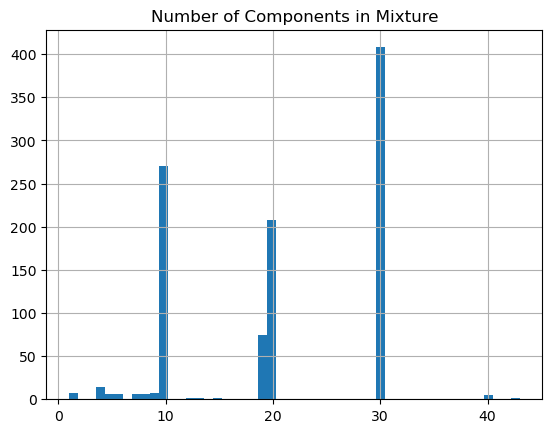

In [35]:
mixture_df.apply(get_cids,axis=1).apply(len).hist(bins=50)
plt.title("Number of Components in Mixture")
plt.show()

### Sanity check: Make sure we have labels for all test cids

In [7]:
for cid in test_cids:
    assert cid in MolecularProperty['CID'].astype(int).values

### Load in the generated Mixture A

In [8]:
mixture_a_df = pd.read_csv("Mixtures/mixture_a_600.csv").drop(columns="Unnamed: 0")
mixture_a_df

,Dataset,Mixture Label,CID,CID.1,CID.2,CID.3,CID.4,CID.5,CID.6,CID.7,CID.8,CID.9
0,in-silico,153931,62465,10882,2758,454,8103,10890,1140,8858,957,6654
1,in-silico,119919,261,6184,62444,1068,5281168,7921,5283349,8186,8635,8797
2,in-silico,105995,10976,62433,6561,2758,10890,18827,12367,5281168,3314,24915
3,in-silico,159593,7714,10882,261,1031,7710,9609,7344,180,7991,10430
4,in-silico,81957,31265,5281515,31276,14286,7762,12178,11509,7799,26331,6654
5,in-silico,75831,12741,6054,31244,12367,7793,8148,15380,443158,10430,7710
6,in-silico,77037,5634,326,93009,61138,7762,12180,1140,61016,22873,7770
7,in-silico,36077,8129,31265,7654,6054,12232,31272,8051,8118,7799,7165
8,in-silico,43223,440967,8103,5281515,7888,8051,1140,8025,22873,7770,6654
9,in-silico,82803,7749,6569,7150,240,7410,15380,8148,180,8635,7966


In [9]:
mixture_a_cids = [get_cids(row) for _, row in mixture_a_df.iterrows()]
mixture_a_labels = [get_norm_mixture_quantile(cids) for cids in mixture_a_cids]
mixture_a_cids[0], mixture_a_labels[0]

(array([62465, 10882,  2758,   454,  8103, 10890,  1140,  8858,   957,
         6654]),
 array([ 0.09052603,  0.10909601,  0.01512861, -0.09518114,  0.10562076,
         0.04299536, -0.0065392 ,  0.08993532,  0.03951274, -0.01009244,
         0.05369199,  0.09458629,  0.01726946,  0.10819385, -0.00341353,
         0.00417349, -0.00385547,  0.01513595, -0.00801614, -0.08657042,
        -0.01143524,  0.15205446, -0.05551728,  0.16357823,  0.14575525,
         0.06955653, -0.04236231, -0.03237737, -0.07637803,  0.04811455,
         0.1538963 ,  0.12669362,  0.10145328, -0.04310944,  0.07723984,
        -0.01609595,  0.0336119 , -0.19200287,  0.19152854,  0.04798753,
         0.03153985,  0.00809808,  0.08342753, -0.0474405 ,  0.12861088,
         0.14412542,  0.06200559,  0.04119252,  0.01481819,  0.06623011,
        -0.02730023,  0.14677558,  0.14207373, -0.01669681,  0.05294621,
         0.10061177,  0.02847244, -0.06004891,  0.05302658,  0.09193405,
         0.06302612, -0.02028262,  0

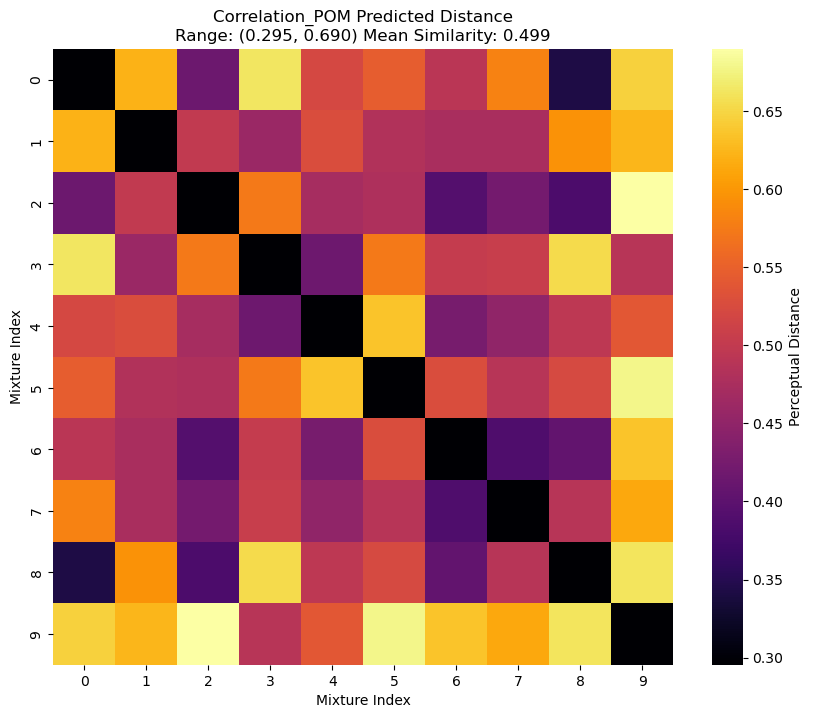

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_similarity_heatmap(similarity_matrix: np.ndarray):
    mins, means, maxs = similarity_matrix.min(), similarity_matrix.mean(), similarity_matrix.max()
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix, cmap='inferno', cbar_kws={'label': 'Perceptual Distance'})
    plt.title(f"Correlation_POM Predicted Distance\nRange: ({mins:.3f}, {maxs:.3f}) Mean Similarity: {means:.3f}")
    plt.xlabel("Mixture Index")
    plt.ylabel("Mixture Index")
    return plt
    
mixture_a_pred_dist = np.zeros((len(mixture_a_labels),len(mixture_a_labels)))
for i, labels_i in enumerate(mixture_a_labels):
    for j, labels_j in enumerate(mixture_a_labels):
        mixture_a_pred_dist[i,j] = perceptual_dist(labels_i, labels_j)

sim_plt = plot_similarity_heatmap(mixture_a_pred_dist)
sim_plt.show()

In [11]:
MIN_SIZE = 9
MAX_SIZE = 11

# Change this to keep generating until we have at least 9.
def generate_greedy_mixture(target_cids, target_sim = 0, display=False, blend_size=MAX_SIZE):
    valid_cids = [cid for cid in test_cids if cid not in target_cids]
    target_labels = get_norm_mixture_quantile(target_cids)

    current_blend = []
    current_distance = float('inf')
    current_error = float('inf')
    current_embed = None
    

    while len(current_blend) < blend_size:
        if display:
            print(f"Step {len(current_blend)} w/ distance {current_distance:.2f}")

        # Find all possible next blends and their labels
        step_blends = [current_blend + [cid] for cid in valid_cids if cid not in current_blend]
        step_labels = [get_norm_mixture_quantile(cids) for cids in step_blends]

        # Calculate the distance and error from each possible blend to the target
        
        step_sims = np.array([perceptual_dist(target_labels, sl) for sl in step_labels])
        step_errors = np.abs(step_sims-target_sim)

        # Find the best next blend
        best_idx = np.argmin(step_errors)
        best_error = step_errors[best_idx]
        best_blend = step_blends[best_idx]
        
        # Don't stop calculating the final result until we have at least the minimum number of components
        if len(best_blend) < MIN_SIZE:
            current_blend = best_blend
            continue

        if best_error < current_error:
            current_blend = best_blend
            current_error = best_error
            current_distance = step_sims[best_idx]
        else:
            break

    return current_blend, current_distance, current_error

ex_target = mixture_a_cids[0]
generate_greedy_mixture(ex_target,target_sim=.6,display=True)

Step 0 w/ distance inf
Step 1 w/ distance inf
Step 2 w/ distance inf
Step 3 w/ distance inf
Step 4 w/ distance inf
Step 5 w/ distance inf
Step 6 w/ distance inf
Step 7 w/ distance inf
Step 8 w/ distance inf
Step 9 w/ distance 0.60


([11002, 4133, 62433, 7654, 31265, 1031, 62336, 5283349, 5634],
 0.5988978837289747,
 0.0011021162710252996)

In [12]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

STEP = .1

all_mixture_b_data = []
quantile_range = np.arange(0, 1+STEP, STEP)
total_steps = len(mixture_a_df) * len(quantile_range)

with tqdm(total=total_steps) as pbar:
    for _, row in mixture_a_df.iterrows():
        mixture_a = get_cids(row)
        mixture_a_label = row["Mixture Label"]

        for quantile_sim in quantile_range:
            blend, distance, error = generate_greedy_mixture(mixture_a, target_sim=quantile_sim, display=False)
            all_mixture_b_data.append({
                "Mixture A": mixture_a_label,
                "Mixture B Blend": blend,
                "Quantile": quantile_sim,
                "Distance": distance,
                "Error": error
            })
            pbar.update(1)

mixture_b_df = pd.DataFrame(all_mixture_b_data)
mixture_b_df

  0%|          | 0/110 [00:00<?, ?it/s]

,Mixture A,Mixture B Blend,Quantile,Distance,Error
0,153931,"[440967, 8129, 180, 5281515, 22873, 7460, 2238...",0.0,0.316213,0.316213
1,153931,"[440967, 8129, 180, 5281515, 22873, 7460, 2238...",0.1,0.316213,0.216213
2,153931,"[440967, 8129, 180, 5281515, 22873, 7460, 2238...",0.2,0.316213,0.116213
3,153931,"[440967, 8129, 180, 5281515, 22873, 7460, 2238...",0.3,0.316213,0.016213
4,153931,"[7460, 7793, 7921, 8130, 62433, 8051, 12178, 6...",0.4,0.400146,0.000146
...,...,...,...,...,...
105,82803,"[6501, 31265, 8103, 7654, 10821, 12232, 8892, ...",0.6,0.598965,0.001035
106,82803,"[7888, 11002, 3314, 8892, 6184, 326, 8051, 108...",0.7,0.699606,0.000394
107,82803,"[7793, 5283349, 7460, 8091, 7921, 62336, 5634,...",0.8,0.799817,0.000183
108,82803,"[7793, 5283349, 7460, 8091, 7921, 62336, 5634,...",0.9,0.803446,0.096554


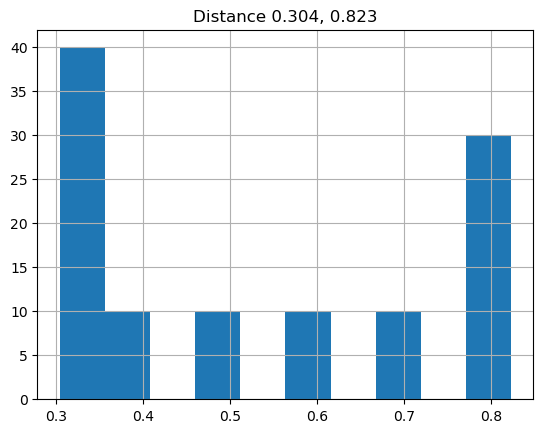

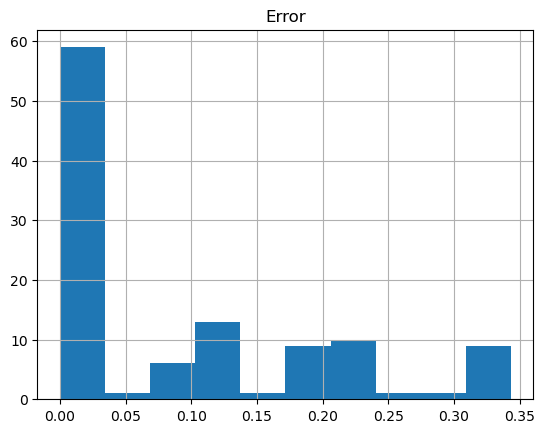

Mixture B Blend
9     54
10    29
11    27
Name: count, dtype: int64

In [13]:
mixture_b_df.hist("Distance")
plt.title(f"Distance {mixture_b_df['Distance'].min():.3f}, {mixture_b_df['Distance'].max():.3f}")
plt.show()

mixture_b_df.hist("Error")
plt.show()

mixture_b_df["Mixture B Blend"].apply(len).value_counts()

In [14]:
import itertools

mixture_b_cids = [f"CID.{i}" for i in range(MAX_SIZE)]

mixture_b_cid_df = pd.DataFrame(mixture_b_df["Mixture B Blend"].map(lambda cids: dict(itertools.zip_longest(mixture_b_cids, cids, fillvalue=np.nan))).tolist())
mixture_b_cid_df

,CID.0,CID.1,CID.2,CID.3,CID.4,CID.5,CID.6,CID.7,CID.8,CID.9,CID.10
0,440967,8129,180,5281515,22873,7460,22386,6544,8130,1031.0,3314.0
1,440967,8129,180,5281515,22873,7460,22386,6544,8130,1031.0,3314.0
2,440967,8129,180,5281515,22873,7460,22386,6544,8130,1031.0,3314.0
3,440967,8129,180,5281515,22873,7460,22386,6544,8130,1031.0,3314.0
4,7460,7793,7921,8130,62433,8051,12178,6054,8129,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
105,6501,31265,8103,7654,10821,12232,8892,6184,7921,NaN,NaN
106,7888,11002,3314,8892,6184,326,8051,10890,7921,7710.0,18827.0
107,7793,5283349,7460,8091,7921,62336,5634,6544,18827,3314.0,11002.0
108,7793,5283349,7460,8091,7921,62336,5634,6544,18827,24915.0,3314.0


In [15]:
output_df = pd.concat([mixture_b_df,mixture_b_cid_df],axis=1).drop(columns="Mixture B Blend")
output_df

,Mixture A,Quantile,Distance,Error,CID.0,CID.1,CID.2,CID.3,CID.4,CID.5,CID.6,CID.7,CID.8,CID.9,CID.10
0,153931,0.0,0.316213,0.316213,440967,8129,180,5281515,22873,7460,22386,6544,8130,1031.0,3314.0
1,153931,0.1,0.316213,0.216213,440967,8129,180,5281515,22873,7460,22386,6544,8130,1031.0,3314.0
2,153931,0.2,0.316213,0.116213,440967,8129,180,5281515,22873,7460,22386,6544,8130,1031.0,3314.0
3,153931,0.3,0.316213,0.016213,440967,8129,180,5281515,22873,7460,22386,6544,8130,1031.0,3314.0
4,153931,0.4,0.400146,0.000146,7460,7793,7921,8130,62433,8051,12178,6054,8129,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,82803,0.6,0.598965,0.001035,6501,31265,8103,7654,10821,12232,8892,6184,7921,NaN,NaN
106,82803,0.7,0.699606,0.000394,7888,11002,3314,8892,6184,326,8051,10890,7921,7710.0,18827.0
107,82803,0.8,0.799817,0.000183,7793,5283349,7460,8091,7921,62336,5634,6544,18827,3314.0,11002.0
108,82803,0.9,0.803446,0.096554,7793,5283349,7460,8091,7921,62336,5634,6544,18827,24915.0,3314.0


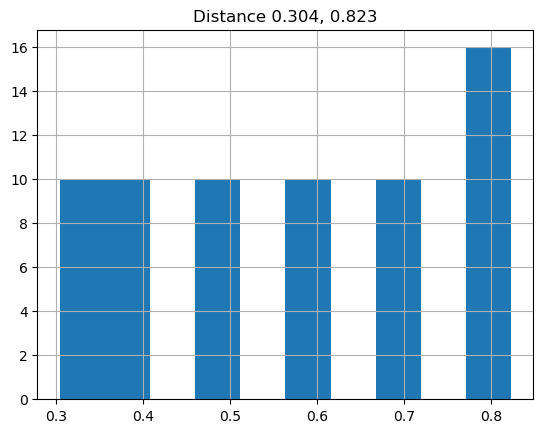

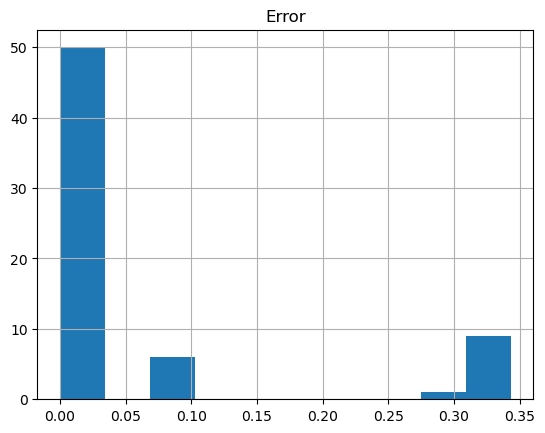

In [32]:
deduplicated_df = output_df.drop_duplicates(["Mixture A"] + mixture_b_cids).copy()

deduplicated_df.hist("Distance")
plt.title(f"Distance {mixture_b_df['Distance'].min():.3f}, {mixture_b_df['Distance'].max():.3f}")
plt.show()

deduplicated_df.hist("Error")
plt.show()

In [33]:
deduplicated_df["Distance"] = deduplicated_df["Distance"].apply(lambda f: f"{f:.2f}")
deduplicated_df.drop(columns=["Quantile","Error"]).reset_index(drop=True).to_csv("Mixtures/mixture_b.csv")